In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/configs/alexnet_sparse_config.py')
model = config.model.to(device)



#general
import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names


/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


### feature target

In [3]:
#feature target

layer = 'features_8'
unit = 150

feature_targets = {layer:[unit]}

### general circuit

In [4]:
import os

general_ranks_folder = 'circuit_ranks/alexnet_sparse/imagenet_2/actxgrad/'
general_rank_files = os.listdir(general_ranks_folder)
for file in general_rank_files:
    if '_'+layer+':'+str(unit)+'_' in file:
        print('found')
        general_ranks = torch.load(general_ranks_folder+file)
        break

found


In [5]:
import pickle
df = pickle.load(open('./extracted_circuits/circuit_with20force_df.pkl','rb'))

In [6]:
df.loc[(df['model']=='alexnet_sparse') & (df['layer']==layer) & (df['method']=='actxgrad') & (df['unit']==unit)][['sparsity','effective_sparsity','pruned_pearson']]

,sparsity,effective_sparsity,pruned_pearson
40058,0.001,0.000000,0.000000
40059,0.005,0.000300,-0.031949
40060,0.010,0.002275,0.157514
40061,0.050,0.040685,0.382373
40062,0.100,0.097711,0.765643
40063,0.200,0.199730,0.945112
40064,0.300,0.299982,0.993931
40065,0.400,0.399933,0.999968
40066,0.500,0.499307,1.000000
40067,0.600,0.599744,1.000000


In [5]:
from circuit_pruner.extraction import model_ranks_2_circuit_model
from circuit_pruner.utils import circuit_2_model_sparsity

sparsity = .4

general_circuit,general_mask = model_ranks_2_circuit_model(general_ranks,sparsity,model,
                                                                     feature_targets,device,structure='edges',
                                                                     use_effective_mask=True)

general_circuit = general_circuit.eval().to('cpu')

for l in general_mask:
    l = l.to('cpu')
    
    
circuit_feature_targets = {layer:[0]}

general_circuit_sparsity_factor = circuit_2_model_sparsity(general_circuit,model)

features_8 effective last layer
target sparsity: 0.4
total params to feature: 86592

kept params in original mask: 34637      (total params * sparsity)
original mask: 495308 params
effective mask: 495254 params
effective_sparsity: 0.39992147080561713
filter sparsity: 0.6545292867701404
kernel sparsity: 0.6110062282760202


In [6]:
general_circuit_sparsity_factor

0.39992147080561713

#### feature visualization of general circuit

100%|██████████| 512/512 [00:17<00:00, 28.54it/s]



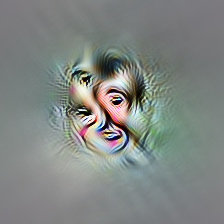

In [8]:
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers


#this is a bit of a hack to get visualizations to work

from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model

dis_general_circuit = dissect_model(deepcopy(general_circuit), store_ranks = True, device=device)
dis_general_circuit = dis_general_circuit.to(device).eval()



param_f = lambda: param.image(224)

obj  = objectives.neuron(layer,0)

featviz = render.render_vis(dis_general_circuit,  obj, param_f, show_inline=True) #weird hack here using the 'dissected_model' works better for neuron-wise feature visualizations, not sure why


### Extracting Profile and Frontal Circuits

### dataloaders

#### preprocess

We want our images to be 'fit' inside the receptive field of our target, we can integrate this step right into the dataloader's transform 

In [7]:
from torchvision import transforms
from circuit_pruner.receptive_fields import receptive_field_fit_transform

target_position = [5,5]   #which location of the target filter's activation map do we want to fit these images to
rff_transform = receptive_field_fit_transform(layer,target_position,model=general_circuit,shrinkage=.8)
#try adding the argument "shrinkage = .5" above

preprocess = config.preprocess
preprocess =  transforms.Compose([preprocess,
                                  rff_transform])

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [244, 244]        0.5        1.0             1.0 
        1               [60, 60]        3.5        4.0            11.0 
        2               [60, 60]        3.5        4.0            11.0 
        3               [29, 29]        7.5        8.0            19.0 
        4               [29, 29]        7.5        8.0            51.0 
        5               [29, 29]        7.5        8.0            51.0 
        6               [14, 14]       15.5       16.0            67.0 
        7               [14, 14]       15.5       16.0            99.0 
        8               [14, 14]       15.5       16.0            99.0 
        9               [14, 14]       15.5       16.0           131.0 
[(30.0, 161.0), (30.0, 161.0)]


/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


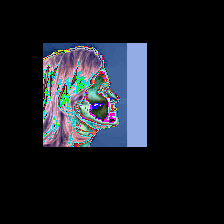

In [8]:
from PIL import Image, ImageOps
from torchvision import transforms

topil = transforms.ToPILImage()

img_path = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/image_data/faces/profile/f19_s_r.jpg'
img = Image.open(img_path)
img_t = preprocess(img)
img = topil(img_t)
img

#### dataloader classes

In [9]:
from circuit_pruner.data_loading import rank_image_data
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data


root_faces_dir ='/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/image_data/faces/'


kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}

aspects = ['front','left','right']

dataloaders = {}

for aspect in aspects:
    dataloaders[aspect] = data.DataLoader(rank_image_data(root_faces_dir+aspect,preprocess),
                                        batch_size=5,shuffle=False,**kwargs)


#### generate ranks

In [10]:
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node
from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model

structure = 'kernels'

ranks = {}


for aspect in aspects:
    print(aspect)
    
    rankable_model = dissect_model(deepcopy(general_circuit), dissect=True,store_ranks = True, device=device)
    rankable_model.to(device)

    set_model_target_node(rankable_model,layer,0)

    set_across_model(rankable_model,'rank_field',target_position)#we want to get ranks with respect to our filters response at the target position 

    set_across_model(rankable_model,'absolute_rank',True)
    
    iter_dataloader = iter(dataloaders[aspect])
    iters = len(iter_dataloader)

    #actually extract ranks by running images through model
    clear_ranks_across_model(rankable_model)

    for it in range(iters):

        inputs, label = next(iter_dataloader)
        inputs = inputs.to(device)

        rankable_model.zero_grad()

        try:
            outputs = rankable_model(inputs)
        except:
            pass


    ranks[aspect] = get_ranklist_from_dissected_Conv2d_modules(rankable_model)
    
    del rankable_model
    torch.cuda.empty_cache()

front
left
right


In [11]:
from circuit_pruner.ranks import minmax_norm_ranks

normed_ranks = {}
for aspect in aspects:
    normed_ranks[aspect] = minmax_norm_ranks(ranks[aspect])

#### dataloaders with larger batch size

In [12]:
from circuit_pruner.data_loading import rank_image_data
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data


root_faces_dir ='/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/image_data/faces/'


kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}

aspects = ['front','left','right']

dataloaders = {}

for aspect in aspects:
    dataloaders[aspect] = data.DataLoader(rank_image_data(root_faces_dir+aspect,preprocess),
                                        batch_size=40,shuffle=False,**kwargs)


#### activation preservation as function of sparsity

In [19]:
from circuit_pruner.extraction import get_preservation_at_sparsities
import numpy as np


structure='kernels'

sparsities = np.linspace(.9999, .01, num=70)

model_sparsities = []
for sparsity in sparsities:
    model_sparsities.append(sparsity*general_circuit_sparsity_factor) 


scores = {'front_circuit':{},
          'left_circuit':{},
          'right_circuit':{},
          'profile_circuit':{},
         }

for rank_aspect in aspects:
    for data_aspect in aspects:
        print('\n\n\n')
        print(rank_aspect)
        print(data_aspect)
        print('\n\n\n')
        scores[rank_aspect+'_circuit'][data_aspect+'_data'] = get_preservation_at_sparsities(
            
                                                                general_circuit,
                                                                ranks[rank_aspect],
                                                                circuit_feature_targets,
                                                                dataloaders[data_aspect],
                                                                sparsities,device,metric='all',
                                                                rank_field = target_position,
                                                                structure=structure)






front
front




original
features_8 effective last layer
average orig acts:
feature features_8:0: 21.704315185546875
Target Sparsity: 0.9999
features_8 effective last layer
target sparsity: 0.9999
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 34627      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 495254 params
effective mask: 495254 params
effective_sparsity: 1.0
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.704315185546875
Target Sparsity: 0.9855536231884058
features_8 effective last layer


features_8 effective last layer
average circuit acts:
feature features_8:0: 21.755205154418945
Target Sparsity: 0.8133971014492754
features_8 effective last layer
target sparsity: 0.8133971014492754
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 28168      (total params * sparsity)
original mask: 431272 params
effective mask: 430696 params
effective_sparsity: 0.8115506786023678
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.76797866821289
Target Sparsity: 0.7990507246376812
features_8 effective last layer
target sparsity: 0.7990507246376812
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sur

features_8 effective last layer
average circuit acts:
feature features_8:0: 20.80732536315918
Target Sparsity: 0.6268942028985507
features_8 effective last layer
target sparsity: 0.6268942028985507
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 21710      (total params * sparsity)
original mask: 353150 params
effective mask: 352846 params
effective_sparsity: 0.6259890268553278
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.100101470947266
Target Sparsity: 0.6125478260869566
features_8 effective last layer
target sparsity: 0.6125478260869566
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sur

features_8 effective last layer
average circuit acts:
feature features_8:0: 21.30923843383789
Target Sparsity: 0.44039130434782614
features_8 effective last layer
target sparsity: 0.44039130434782614
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 15251      (total params * sparsity)
original mask: 265259 params
effective mask: 264791 params
effective_sparsity: 0.4388969101934739
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.371479034423828
Target Sparsity: 0.4260449275362319
features_8 effective last layer
target sparsity: 0.4260449275362319
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 21.220060348510742
Target Sparsity: 0.2538884057971015
features_8 effective last layer
target sparsity: 0.2538884057971015
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 8793      (total params * sparsity)
original mask: 164721 params
effective mask: 164451 params
effective_sparsity: 0.25304649148137454
features_8 effective last layer
average circuit acts:
feature features_8:0: 22.25502586364746
Target Sparsity: 0.23954202898550725
features_8 effective last layer
target sparsity: 0.23954202898550725
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.672396659851074
Target Sparsity: 0.06738550724637682
features_8 effective last layer
target sparsity: 0.06738550724637682
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 2334      (total params * sparsity)
original mask: 50222 params
effective mask: 46281 params
effective_sparsity: 0.057782269708345366
features_8 effective last layer
average circuit acts:
feature features_8:0: 9.532295227050781
Target Sparsity: 0.05303913043478259
features_8 effective last layer
target sparsity: 0.05303913043478259
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.88890266418457
Target Sparsity: 0.8851289855072464
features_8 effective last layer
target sparsity: 0.8851289855072464
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 30653      (total params * sparsity)
original mask: 457829 params
effective mask: 457505 params
effective_sparsity: 0.8841178169217442
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.878700256347656
Target Sparsity: 0.8707826086956522
features_8 effective last layer
target sparsity: 0.8707826086956522
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sur

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.33765697479248
Target Sparsity: 0.6986260869565217
features_8 effective last layer
target sparsity: 0.6986260869565217
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 24194      (total params * sparsity)
original mask: 384482 params
effective mask: 384068 params
effective_sparsity: 0.6973144672249495
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.724108695983887
Target Sparsity: 0.6842797101449276
features_8 effective last layer
target sparsity: 0.6842797101449276
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sur

features_8 effective last layer
average circuit acts:
feature features_8:0: 12.353696823120117
Target Sparsity: 0.5121231884057971
features_8 effective last layer
target sparsity: 0.5121231884057971
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 17735      (total params * sparsity)
original mask: 300607 params
effective mask: 300391 params
effective_sparsity: 0.5114351718163442
features_8 effective last layer
average circuit acts:
feature features_8:0: 12.04865550994873
Target Sparsity: 0.49777681159420295
features_8 effective last layer
target sparsity: 0.49777681159420295
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 9.077574729919434
Target Sparsity: 0.3256202898550725
features_8 effective last layer
target sparsity: 0.3256202898550725
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 11277      (total params * sparsity)
original mask: 204613 params
effective mask: 204217 params
effective_sparsity: 0.3243719318509962
features_8 effective last layer
average circuit acts:
feature features_8:0: 8.978389739990234
Target Sparsity: 0.3112739130434783
features_8 effective last layer
target sparsity: 0.3112739130434783
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure

features_8 effective last layer
average circuit acts:
feature features_8:0: 6.027097702026367
Target Sparsity: 0.13911739130434786
features_8 effective last layer
target sparsity: 0.13911739130434786
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 4818      (total params * sparsity)
original mask: 96018 params
effective mask: 94799 params
effective_sparsity: 0.1355760900952931
features_8 effective last layer
average circuit acts:
feature features_8:0: 4.975279808044434
Target Sparsity: 0.12477101449275363
features_8 effective last layer
target sparsity: 0.12477101449275363
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sur

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.772506713867188
Target Sparsity: 0.9568608695652174
features_8 effective last layer
target sparsity: 0.9568608695652174
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 33137      (total params * sparsity)
original mask: 481417 params
effective mask: 481318 params
effective_sparsity: 0.9565694484550967
features_8 effective last layer
average circuit acts:
feature features_8:0: 10.866493225097656
Target Sparsity: 0.9425144927536232
features_8 effective last layer
target sparsity: 0.9425144927536232
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.711846351623535
Target Sparsity: 0.7703579710144928
features_8 effective last layer
target sparsity: 0.7703579710144928
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 26678      (total params * sparsity)
original mask: 414198 params
effective mask: 413964 params
effective_sparsity: 0.7696217152757725
features_8 effective last layer
average circuit acts:
feature features_8:0: 10.705656051635742
Target Sparsity: 0.7560115942028985
features_8 effective last layer
target sparsity: 0.7560115942028985
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.634810447692871
Target Sparsity: 0.5838550724637681
features_8 effective last layer
target sparsity: 0.5838550724637681
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 20219      (total params * sparsity)
original mask: 333507 params
effective mask: 333149 params
effective_sparsity: 0.582760612185966
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.917614936828613
Target Sparsity: 0.569508695652174
features_8 effective last layer
target sparsity: 0.569508695652174
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure,

features_8 effective last layer
average circuit acts:
feature features_8:0: 9.583395957946777
Target Sparsity: 0.39735217391304345
features_8 effective last layer
target sparsity: 0.39735217391304345
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 13761      (total params * sparsity)
original mask: 243257 params
effective mask: 242683 params
effective_sparsity: 0.3955818654345943
features_8 effective last layer
average circuit acts:
feature features_8:0: 9.210627555847168
Target Sparsity: 0.38300579710144933
features_8 effective last layer
target sparsity: 0.38300579710144933
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 8.43397045135498
Target Sparsity: 0.2108492753623189
features_8 effective last layer
target sparsity: 0.2108492753623189
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 7302      (total params * sparsity)
original mask: 139350 params
effective mask: 138540 params
effective_sparsity: 0.20825873520069305
features_8 effective last layer
average circuit acts:
feature features_8:0: 7.773024082183838
Target Sparsity: 0.19650289855072467
features_8 effective last layer
target sparsity: 0.19650289855072467
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sur

features_8 effective last layer
average circuit acts:
feature features_8:0: 5.630640029907227
Target Sparsity: 0.02434637681159424
features_8 effective last layer
target sparsity: 0.02434637681159424
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 844      (total params * sparsity)
original mask: 19036 params
effective mask: 14617 params
effective_sparsity: 0.014813745307536819
features_8 effective last layer
average circuit acts:
feature features_8:0: 4.691299915313721
Target Sparsity: 0.01
features_8 effective last layer
target sparsity: 0.01
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these p

features_8 effective last layer
average circuit acts:
feature features_8:0: 21.729005813598633
Target Sparsity: 0.8420898550724638
features_8 effective last layer
target sparsity: 0.8420898550724638
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 29162      (total params * sparsity)
original mask: 440810 params
effective mask: 440720 params
effective_sparsity: 0.8418134565405717
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.744491577148438
Target Sparsity: 0.8277434782608696
features_8 effective last layer
target sparsity: 0.8277434782608696
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 19.386306762695312
Target Sparsity: 0.6555869565217392
features_8 effective last layer
target sparsity: 0.6555869565217392
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 22703      (total params * sparsity)
original mask: 362631 params
effective mask: 362514 params
effective_sparsity: 0.6552122437193185
features_8 effective last layer
average circuit acts:
feature features_8:0: 19.315248489379883
Target Sparsity: 0.6412405797101449
features_8 effective last layer
target sparsity: 0.6412405797101449
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 23.12966537475586
Target Sparsity: 0.4690840579710145
features_8 effective last layer
target sparsity: 0.4690840579710145
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 16245      (total params * sparsity)
original mask: 275069 params
effective mask: 274853 params
effective_sparsity: 0.46840889402252384
features_8 effective last layer
average circuit acts:
feature features_8:0: 22.730716705322266
Target Sparsity: 0.45473768115942037
features_8 effective last layer
target sparsity: 0.45473768115942037
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 21.54813575744629
Target Sparsity: 0.28258115942028983
features_8 effective last layer
target sparsity: 0.28258115942028983
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 9786      (total params * sparsity)
original mask: 177242 params
effective mask: 176945 params
effective_sparsity: 0.28163442102223507
features_8 effective last layer
average circuit acts:
feature features_8:0: 22.191381454467773
Target Sparsity: 0.2682347826086957
features_8 effective last layer
target sparsity: 0.2682347826086957
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 12.612836837768555
Target Sparsity: 0.09607826086956528
features_8 effective last layer
target sparsity: 0.09607826086956528
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 3328      (total params * sparsity)
original mask: 67536 params
effective mask: 64929 params
effective_sparsity: 0.0903551833670228
features_8 effective last layer
average circuit acts:
feature features_8:0: 13.261537551879883
Target Sparsity: 0.08173188405797105
features_8 effective last layer
target sparsity: 0.08173188405797105
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.709393501281738
Target Sparsity: 0.9138217391304349
features_8 effective last layer
target sparsity: 0.9138217391304349
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 31646      (total params * sparsity)
original mask: 466974 params
effective mask: 466965 params
effective_sparsity: 0.9138030609298297
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.699165344238281
Target Sparsity: 0.8994753623188406
features_8 effective last layer
target sparsity: 0.8994753623188406
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.492409706115723
Target Sparsity: 0.7273188405797102
features_8 effective last layer
target sparsity: 0.7273188405797102
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 25188      (total params * sparsity)
original mask: 393652 params
effective mask: 393589 params
effective_sparsity: 0.7271440947155645
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.839056968688965
Target Sparsity: 0.712972463768116
features_8 effective last layer
target sparsity: 0.712972463768116
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.615277290344238
Target Sparsity: 0.5408159420289855
features_8 effective last layer
target sparsity: 0.5408159420289855
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 18729      (total params * sparsity)
original mask: 310049 params
effective mask: 309950 params
effective_sparsity: 0.5405140051978053
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.543325424194336
Target Sparsity: 0.5264695652173913
features_8 effective last layer
target sparsity: 0.5264695652173913
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.34853744506836
Target Sparsity: 0.35431304347826087
features_8 effective last layer
target sparsity: 0.35431304347826087
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 12270      (total params * sparsity)
original mask: 216014 params
effective mask: 215638 params
effective_sparsity: 0.3531619982673982
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.26024341583252
Target Sparsity: 0.33996666666666675
features_8 effective last layer
target sparsity: 0.33996666666666675
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 9.637322425842285
Target Sparsity: 0.1678101449275362
features_8 effective last layer
target sparsity: 0.1678101449275362
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 5812      (total params * sparsity)
original mask: 111460 params
effective mask: 110606 params
effective_sparsity: 0.16534796419289632
features_8 effective last layer
average circuit acts:
feature features_8:0: 9.424567222595215
Target Sparsity: 0.1534637681159421
features_8 effective last layer
target sparsity: 0.1534637681159421
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.785665512084961
Target Sparsity: 0.9855536231884058
features_8 effective last layer
target sparsity: 0.9855536231884058
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 34130      (total params * sparsity)
original mask: 490690 params
effective mask: 490681 params
effective_sparsity: 0.9855327750505343
features_8 effective last layer
average circuit acts:
feature features_8:0: 10.778186798095703
Target Sparsity: 0.9712072463768116
features_8 effective last layer
target sparsity: 0.9712072463768116
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.749341011047363
Target Sparsity: 0.7990507246376812
features_8 effective last layer
target sparsity: 0.7990507246376812
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 27672      (total params * sparsity)
original mask: 423848 params
effective mask: 423722 params
effective_sparsity: 0.7986716719607277
features_8 effective last layer
average circuit acts:
feature features_8:0: 10.77823543548584
Target Sparsity: 0.784704347826087
features_8 effective last layer
target sparsity: 0.784704347826087
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure,

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.1778564453125
Target Sparsity: 0.6125478260869566
features_8 effective last layer
target sparsity: 0.6125478260869566
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 21213      (total params * sparsity)
original mask: 343333 params
effective mask: 343146 params
effective_sparsity: 0.6120127057464626
features_8 effective last layer
average circuit acts:
feature features_8:0: 10.646410942077637
Target Sparsity: 0.5982014492753623
features_8 effective last layer
target sparsity: 0.5982014492753623
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.050515174865723
Target Sparsity: 0.4260449275362319
features_8 effective last layer
target sparsity: 0.4260449275362319
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 14754      (total params * sparsity)
original mask: 253442 params
effective mask: 253185 params
effective_sparsity: 0.4253248628356916
features_8 effective last layer
average circuit acts:
feature features_8:0: 10.840109825134277
Target Sparsity: 0.4116985507246377
features_8 effective last layer
target sparsity: 0.4116985507246377
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.580357551574707
Target Sparsity: 0.23954202898550725
features_8 effective last layer
target sparsity: 0.23954202898550725
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 8296      (total params * sparsity)
original mask: 153240 params
effective mask: 152866 params
effective_sparsity: 0.23846375974588507
features_8 effective last layer
average circuit acts:
feature features_8:0: 9.695272445678711
Target Sparsity: 0.22519565217391313
features_8 effective last layer
target sparsity: 0.22519565217391313
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making

features_8 effective last layer
average circuit acts:
feature features_8:0: 5.9563469886779785
Target Sparsity: 0.05303913043478259
features_8 effective last layer
target sparsity: 0.05303913043478259
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 1837      (total params * sparsity)
original mask: 38469 params
effective mask: 33931 params
effective_sparsity: 0.04166907305804216
features_8 effective last layer
average circuit acts:
feature features_8:0: 1.2310785055160522
Target Sparsity: 0.03869275362318847
features_8 effective last layer
target sparsity: 0.03869275362318847
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 21.79268455505371
Target Sparsity: 0.8707826086956522
features_8 effective last layer
target sparsity: 0.8707826086956522
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 30156      (total params * sparsity)
original mask: 451708 params
effective mask: 451447 params
effective_sparsity: 0.8699682356338435
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.82746696472168
Target Sparsity: 0.8564362318840579
features_8 effective last layer
target sparsity: 0.8564362318840579
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure

features_8 effective last layer
average circuit acts:
feature features_8:0: 21.968637466430664
Target Sparsity: 0.6842797101449276
features_8 effective last layer
target sparsity: 0.6842797101449276
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 23697      (total params * sparsity)
original mask: 374937 params
effective mask: 374847 params
effective_sparsity: 0.6840023101357204
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.73546028137207
Target Sparsity: 0.6699333333333334
features_8 effective last layer
target sparsity: 0.6699333333333334
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sur

features_8 effective last layer
average circuit acts:
feature features_8:0: 22.397701263427734
Target Sparsity: 0.49777681159420295
features_8 effective last layer
target sparsity: 0.49777681159420295
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 17239      (total params * sparsity)
original mask: 289151 params
effective mask: 289007 params
effective_sparsity: 0.4973433439214554
features_8 effective last layer
average circuit acts:
feature features_8:0: 22.40829849243164
Target Sparsity: 0.4834304347826087
features_8 effective last layer
target sparsity: 0.4834304347826087
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 21.14108657836914
Target Sparsity: 0.3112739130434783
features_8 effective last layer
target sparsity: 0.3112739130434783
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 10780      (total params * sparsity)
original mask: 192620 params
effective mask: 192228 params
effective_sparsity: 0.31013572047357785
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.402069091796875
Target Sparsity: 0.29692753623188406
features_8 effective last layer
target sparsity: 0.29692753623188406
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 12.547409057617188
Target Sparsity: 0.12477101449275363
features_8 effective last layer
target sparsity: 0.12477101449275363
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 4321      (total params * sparsity)
original mask: 85849 params
effective mask: 84606 params
effective_sparsity: 0.12099335835980364
features_8 effective last layer
average circuit acts:
feature features_8:0: 12.349102973937988
Target Sparsity: 0.11042463768115951
features_8 effective last layer
target sparsity: 0.11042463768115951
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.725257873535156
Target Sparsity: 0.9425144927536232
features_8 effective last layer
target sparsity: 0.9425144927536232
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 32640      (total params * sparsity)
original mask: 476672 params
effective mask: 476654 params
effective_sparsity: 0.9424776205602079
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.71635627746582
Target Sparsity: 0.928168115942029
features_8 effective last layer
target sparsity: 0.928168115942029
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure,

features_8 effective last layer
average circuit acts:
feature features_8:0: 12.16871452331543
Target Sparsity: 0.7560115942028985
features_8 effective last layer
target sparsity: 0.7560115942028985
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 26181      (total params * sparsity)
original mask: 405645 params
effective mask: 405447 params
effective_sparsity: 0.755385503898354
features_8 effective last layer
average circuit acts:
feature features_8:0: 12.087080955505371
Target Sparsity: 0.7416652173913043
features_8 effective last layer
target sparsity: 0.7416652173913043
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.16673755645752
Target Sparsity: 0.569508695652174
features_8 effective last layer
target sparsity: 0.569508695652174
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 19723      (total params * sparsity)
original mask: 323411 params
effective mask: 323303 params
effective_sparsity: 0.5691885648281837
features_8 effective last layer
average circuit acts:
feature features_8:0: 12.06464958190918
Target Sparsity: 0.5551623188405798
features_8 effective last layer
target sparsity: 0.5551623188405798
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, 

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.205546379089355
Target Sparsity: 0.38300579710144933
features_8 effective last layer
target sparsity: 0.38300579710144933
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 13264      (total params * sparsity)
original mask: 231088 params
effective mask: 230773 params
effective_sparsity: 0.382009818076812
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.595641136169434
Target Sparsity: 0.3686594202898551
features_8 effective last layer
target sparsity: 0.3686594202898551
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 9.186594009399414
Target Sparsity: 0.19650289855072467
features_8 effective last layer
target sparsity: 0.19650289855072467
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 6805      (total params * sparsity)
original mask: 128141 params
effective mask: 127142 params
effective_sparsity: 0.19376263355472134
features_8 effective last layer
average circuit acts:
feature features_8:0: 9.1082181930542
Target Sparsity: 0.18215652173913044
features_8 effective last layer
target sparsity: 0.18215652173913044
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

average circuit acts:
feature features_8:0: 0.7133192420005798
Target Sparsity: 0.01
features_8 effective last layer
target sparsity: 0.01
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 347      (total params * sparsity)
original mask: 7619 params
effective mask: 3013 params
effective_sparsity: 0.002685532775050534
features_8 effective last layer
average circuit acts:
feature features_8:0: 0.9373914003372192




right
right




original
features_8 effective last layer
average orig acts:
feature features_8:0: 10.785665512084961
Target Sparsity: 0.9999
features_8 effective last layer
target sparsity: 0.9999
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit 

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.957487106323242
Target Sparsity: 0.8277434782608696
features_8 effective last layer
target sparsity: 0.8277434782608696
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 28665      (total params * sparsity)
original mask: 435185 params
effective mask: 434987 params
effective_sparsity: 0.8271152180190586
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.100018501281738
Target Sparsity: 0.8133971014492754
features_8 effective last layer
target sparsity: 0.8133971014492754
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.06725025177002
Target Sparsity: 0.6412405797101449
features_8 effective last layer
target sparsity: 0.6412405797101449
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 22207      (total params * sparsity)
original mask: 356055 params
effective mask: 355974 params
effective_sparsity: 0.641004909038406
features_8 effective last layer
average circuit acts:
feature features_8:0: 9.600881576538086
Target Sparsity: 0.6268942028985507
features_8 effective last layer
target sparsity: 0.6268942028985507
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure,

features_8 effective last layer
average circuit acts:
feature features_8:0: 11.474114418029785
Target Sparsity: 0.45473768115942037
features_8 effective last layer
target sparsity: 0.45473768115942037
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 15748      (total params * sparsity)
original mask: 267476 params
effective mask: 267206 params
effective_sparsity: 0.4538839156800462
features_8 effective last layer
average circuit acts:
feature features_8:0: 11.114091873168945
Target Sparsity: 0.44039130434782614
features_8 effective last layer
target sparsity: 0.44039130434782614
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just makin

features_8 effective last layer
average circuit acts:
feature features_8:0: 10.060312271118164
Target Sparsity: 0.2682347826086957
features_8 effective last layer
target sparsity: 0.2682347826086957
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 9289      (total params * sparsity)
original mask: 169265 params
effective mask: 168835 params
effective_sparsity: 0.266907305804216
features_8 effective last layer
average circuit acts:
feature features_8:0: 10.38931655883789
Target Sparsity: 0.2538884057971015
features_8 effective last layer
target sparsity: 0.2538884057971015
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure,

features_8 effective last layer
average circuit acts:
feature features_8:0: 4.323014259338379
Target Sparsity: 0.08173188405797105
features_8 effective last layer
target sparsity: 0.08173188405797105
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 2831      (total params * sparsity)
original mask: 58423 params
effective mask: 55592 params
effective_sparsity: 0.07507941091539128
features_8 effective last layer
average circuit acts:
feature features_8:0: 4.359879493713379
Target Sparsity: 0.06738550724637682
features_8 effective last layer
target sparsity: 0.06738550724637682
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

In [14]:
scores['front_circuit']['front_data'][layer+':0'].keys()

dict_keys(['spearman', 'pearson', 'avg_diff', 'avg_abs_diff', 'std_normed_diff', 'mean_normed_diff', 'std_normed_abs_diff'])

In [20]:
import pickle

#pickle.dump(scores,open('face_front_profile_scores','wb'))

In [13]:
import pickle
scores = pickle.load(open('face_front_profile_scores','rb'))

In [15]:
import numpy as np
sparsities = np.linspace(.9999, .01, num=70)

model_sparsities = []
for sparsity in sparsities:
    model_sparsities.append(sparsity*general_circuit_sparsity_factor) 


In [22]:
import plotly.graph_objects as go
import plotly.express as px


x_axis = model_sparsities

metric = 'mean_normed_diff'

color_dict = {
               'front_circuit':px.colors.qualitative.T10[0],
               'left_circuit':px.colors.qualitative.T10[1],
               'right_circuit':px.colors.qualitative.T10[4],
             }

dash_dict = {
               'front_data':None,
               'left_data':'dot',
               'right_data':'dash',
            }


fig = go.Figure()

for circuit in scores:
    third_line = False
    for data in scores[circuit]:
        if data.replace('_data','') == circuit.replace('_circuit',''):
            linetype = None
        elif third_line:
            linetype = 'dot'
        else:
            linetype= 'dash'
            third_line = True
            
            
        # Create and style traces
        y = scores[circuit][data]['%s:%s'%(layer,0)][metric]
        x = x_axis[0:len(scores[circuit][data]['%s:%s'%(layer,0)][metric])]
        fig.add_trace(go.Scatter(x=x, y=y, name=circuit+' : '+data,
                         line=dict(color=color_dict[circuit], width=12,dash=linetype)))

# Edit the layout
fig.update_layout( width = 720,
                   plot_bgcolor = 'rgba(255,255,255,1)',
                   paper_bgcolor = 'rgba(255,255,255,1)',
                   xaxis_title='sparsity',
                   yaxis_title=r'$\Huge{\Delta\mathcal{F}}$',
                  legend=dict(
                                yanchor="top",
                                y=0.65,
                                xanchor="left",
                                x=0.03
                              )
                 )

fig.update_xaxes(autorange="reversed",gridcolor='rgb(210,210,210)',gridwidth=4)
fig.update_yaxes(gridcolor='rgb(210,210,210)',gridwidth=4)

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [.4, .3, .2, .1]
    )
)

fig.show()

In [23]:
from circuit_pruner.visualizer.layouts import big_fig_layout

fig.update_layout(big_fig_layout)
#fig.update_layout({ 'width':3000})

fig.update

fig.update_layout({
                    'height':1200,
                    'width':1600,
                    'font':{'size':50}},
)


fig.update_layout(legend= {'bgcolor': 'rgba(255,255,255,0.3)'})

fig.update_layout(legend=dict(
                                yanchor="top",
                                y=0.3,
                                xanchor="left",
                                x=0.03
                              ))



fig.update_layout(legend=dict(
                             font=dict(size=40)
                    ))

fig.update_layout({'showlegend':False})

In [25]:
fig.write_html("plots/faces_activation_diff_big.html")
fig.write_image("plots/faces_activation_diff_big.svg")
fig.write_image("plots/faces_activation_diff_big.png")

#### Compare IoU of extracted circuits

In [26]:
# extraction at last good sparsity

from circuit_pruner.extraction import model_ranks_2_circuit_model

ranker = ranks

target_sparsities = {'front':0.25,
                     'left':0.25,
                     'right':0.25}



sparse_circuits = {}
sparse_masks = {}

for aspect in aspects:
    sparse_circuit,sparse_mask = model_ranks_2_circuit_model(ranker[aspect],target_sparsities[aspect],
                                                           general_circuit,circuit_feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='max')
    sparse_circuits[aspect] = sparse_circuit.to(device)
    sparse_masks[aspect] = sparse_mask

features_8 effective last layer
target sparsity: 0.25
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 8658      (total params * sparsity)
original mask: 162498 params
effective mask: 162237 params
effective_sparsity: 0.2491770141495813


/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/circuit_pruner/extraction.py:251: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)



features_8 effective last layer
target sparsity: 0.25
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 8658      (total params * sparsity)
original mask: 159282 params
effective mask: 158940 params
effective_sparsity: 0.24891712388102802
features_8 effective last layer
target sparsity: 0.25
total params to feature: 56677

we found 22047 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34630    (after subtracting previously masked params)
kept params in original mask: 8658      (total params * sparsity)
original mask: 159122 params
effective mask: 158719 params
effective_sparsity: 0.24877274039849842


In [27]:
from circuit_pruner.utils import mask_intersect_over_union

comparisons = ['front:right','front:left','right:left']

ious = {}

for comp in comparisons:
    m1_name = comp.split(':')[0]
    m2_name = comp.split(':')[1]
    ious[comp] = mask_intersect_over_union(sparse_masks[m1_name],sparse_masks[m2_name])
    
    
ious['polysemantic'] = [.72,.44,.2,.09,.25]


In [37]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:16<00:00, 31.66it/s]



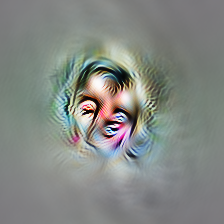

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


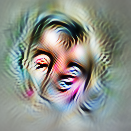

In [39]:
featviz_in_recep_field(deepcopy(sparse_circuits['front']),layer,0,margin=0)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:15<00:00, 33.38it/s]



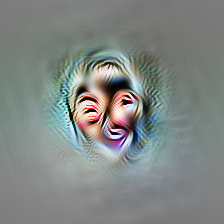

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


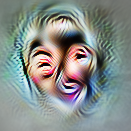

In [44]:
featviz_in_recep_field(deepcopy(sparse_circuits['right']),layer,0,margin=0)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:15<00:00, 32.17it/s]



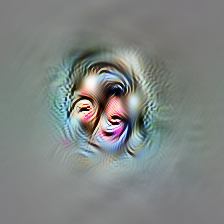

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


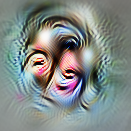

In [45]:
featviz_in_recep_field(deepcopy(sparse_circuits['left']),layer,0,margin=0)

In [28]:
from circuit_pruner.utils import plot_iou_from_masks
iou_fig = plot_iou_from_masks(sparse_masks['front'],sparse_masks['right'])
#iou_fig.update_layout(height = 700,width=1000)

In [29]:
from circuit_pruner.visualizer.layouts import big_fig_layout

iou_fig.update_layout(big_fig_layout)
#fig.update_layout({ 'width':3000})


iou_fig.update_layout({
                    'height':1500,
                    'width':1500,
                    'font':{'size':60}})

In [30]:
iou_fig.write_html("plots/faces_frontright_iou_big.html")
iou_fig.write_image("plots/face_frontright_iou_big.svg")
iou_fig.write_image("plots/face_frontright_iou_big.png")

##### Generate left and right profile folders

In [93]:
import PIL
from PIL import Image
import os


root_dir = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/image_data/faces/'

profile_images = os.listdir(root_dir+'profile/')

for im_name in profile_images:
    im = Image.open(root_dir+'profile/'+im_name)
    direction = im_name.split('.')[0][-1]
    if direction == 'l':
        l_im = im
        r_im = im.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        l_im_name = im_name
        r_im_name = im_name.replace('l','r')
    else:
        r_im = im
        l_im = im.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        r_im_name = im_name
        l_im_name = im_name.replace('r','l')

    r_im.save(root_dir+'right/'+r_im_name)
    l_im.save(root_dir+'left/'+l_im_name)